In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns

#### Funciones

In [2]:
import regex as re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('stopwords')
# Los Df estan en ingles
sw_list = stopwords.words()
sw = set(sw_list)

def tokenize(text: str):
    return re.findall(r'[\w-]*\p{L}[\w-]', text)

def remove_stopwords(words_list: [str]):
    return [word for word in words_list if word not in sw]

def proccess_corpus(text, pipeline):
    temp = text
    for func in pipeline:
        temp = func(temp)
    return temp

def cuenta_palabras_df(df, column='palabras', min_frecuencias=10):
   # crea un contador y cuenta todas las palabras
   contador = Counter()
   df[column].map(contador.update)
  
   #convertir el contador en un dataframe
   frecuencias_df = pd.DataFrame.from_dict(contador, orient='index', columns=['frecuencias'])
   frecuencias_df = frecuencias_df.query('frecuencias >= @min_frecuencias')
  
   frecuencias_df.index.name = 'palabra'
   frecuencias_df.sort_values('frecuencias', ascending=False)
   return frecuencias_df.sort_values('frecuencias', ascending=False)

def obtenProbabilidades(df: pd.DataFrame, sentimientos):
  negativos = []
  neutros = []
  positivos = []
  outputs = []
  for probabilidad in sentimientos:
    negativos.append(probabilidad.probas['NEG'])
    neutros.append(probabilidad.probas['NEU'])
    positivos.append(probabilidad.probas['POS'])
    outputs.append(probabilidad.output)
  probabilidades = {'neg': negativos, 'neu': neutros, 'pos': positivos, 'output': outputs}
  probabilidades = pd.DataFrame.from_dict(probabilidades)
  probabilidades.index = df.index
  return pd.concat([df, probabilidades], axis=1)

def calculaNGrams(corpus, n=None, min_words = 10):
    def dummy_fun(doc):
        return doc
    vector_grams = CountVectorizer(
        ngram_range=(n, n),
        tokenizer=dummy_fun,
        preprocessor=dummy_fun,
        token_pattern=None
    ).fit(corpus)
    bolsa_de_palabras = vector_grams.transform(corpus)
    sumatoria_palabras = bolsa_de_palabras.sum(axis=0) 
    frecuencias_palabras = [(palabra, sumatoria_palabras[0, indice]) \
        for palabra, indice in vector_grams.vocabulary_.items()] 
    frecuencias_palabras = sorted(frecuencias_palabras, key = lambda x: x[1], reverse=True) 
    x,y=map(list,zip(*frecuencias_palabras[:min_words])) 
    sns.barplot(x=y,y=x)

def nube_palabras(corpus, color):
    wordcloud = WordCloud(
        background_color=color,
        stopwords=sw,
        max_words=100,
        max_font_size=45,
        scale=3,
        random_state=1,
    )
    return wordcloud.generate(str(corpus))

def visualizar_palabra_tsne(modelo, palabra, tamanio):
    arreglo = np.empty((0,tamanio), dtype='f')
    etiquetas_palabras = [palabra]
    palabras_cercanas = modelo.similar_by_word(palabra)
    arreglo = np.append(arreglo, np.array([modelo[palabra]]), axis=0)
    for calificacion_palabra in palabras_cercanas:
        vector_palabras = modelo[calificacion_palabra[0]]
        etiquetas_palabras.append(calificacion_palabra[0])
        arreglo = np.append(arreglo, np.array([vector_palabras]), axis=0)
       
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arreglo)
    x_coordinadas = Y[:, 0]
    y_coordinadas = Y[:, 1]
    plt.scatter(x_coordinadas, y_coordinadas)
    for etiqueta, x, y in zip(etiquetas_palabras, x_coordinadas, y_coordinadas):
        plt.annotate(etiqueta, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coordinadas.min()+0.00005, x_coordinadas.max()+0.00005)
    plt.ylim(y_coordinadas.min()+0.00005, y_coordinadas.max()+0.00005)
    plt.show()
     

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
juguetesDF = pd.read_json(r'assets/Toys_and_Games.json', lines=True)
# normalize id
juguetesDF._id = pd.DataFrame.from_records(juguetesDF['_id'])['$oid']

In [4]:
juguetesDF.head()

,_id,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category,class
0,5a13282b741a2384e879a620,A3C9CSW3TJITGT,0005069491,Renee,"[0, 0]",I love these felt nursery rhyme characters and...,4,Charming characters but busy work required,1377561600,"08 27, 2013",Toys_and_Games,1
1,5a13282b741a2384e879a621,A31POTIYCKSZ9G,0076561046,So CA Teacher,"[0, 0]",I see no directions for its use. Therefore I h...,3,No directions for use...,1404864000,"07 9, 2014",Toys_and_Games,0
2,5a13282b741a2384e879a622,A2GGHHME9B6W4O,0131358936,Dalilah G.,"[0, 0]",This is a great tool for any teacher using the...,5,Great CD-ROM,1382400000,"10 22, 2013",Toys_and_Games,1
3,5a13282b741a2384e879a61f,AMEVO2LY6VEJA,0000191639,Nicole Soeder,"[0, 0]","Great product, thank you! Our son loved the pu...",5,Puzzles,1388016000,"12 26, 2013",Toys_and_Games,1
4,5a13282b741a2384e879a623,A1FSLDH43ORWZP,0133642984,Dayna English,"[0, 0]",Although not as streamlined as the Algebra I m...,5,Algebra II -- presentation materials,1374278400,"07 20, 2013",Toys_and_Games,1


In [5]:
juguetesDF['words'] = juguetesDF.reviewText.apply(proccess_corpus, pipeline=[str.lower, tokenize, remove_stopwords])
juguetesDF['freq_review'] = juguetesDF.words.map(len)

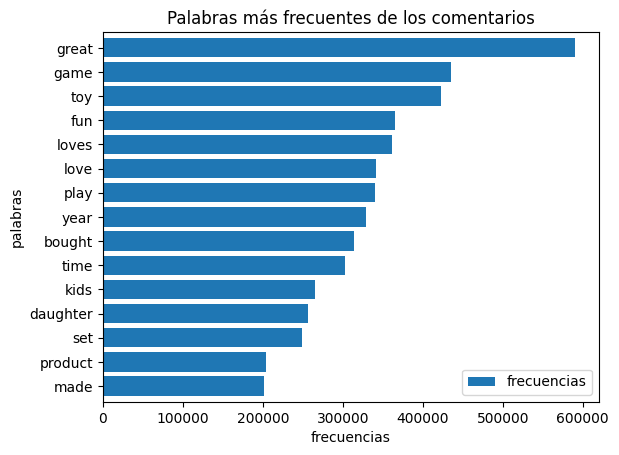

In [6]:
frecuencias_df = cuenta_palabras_df(juguetesDF, 'words', 150)
ax = frecuencias_df.head(15).plot(kind='barh', width=0.80)
ax.invert_yaxis();
ax.set(xlabel='frecuencias', ylabel='palabras', title='Palabras más frecuentes de los comentarios');

In [7]:
freq = juguetesDF.reviewText.apply(lambda x: len(tokenize(x)))

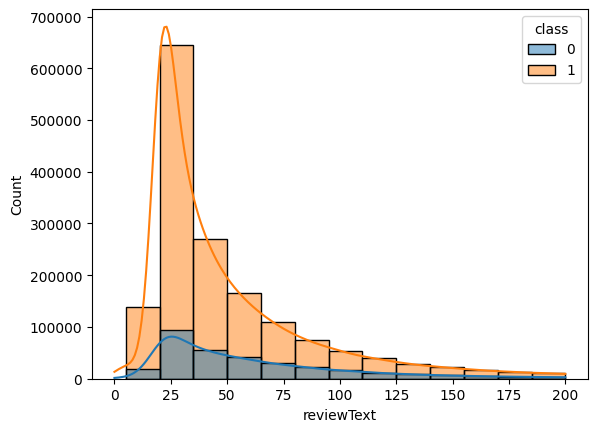

In [8]:
distDF = pd.concat([freq, juguetesDF['class']], axis=1);
sns.histplot(data=distDF, bins=range(5, 210, 15), kde=True, kde_kws={'clip': (0.0, 200)}, hue='class', x='reviewText');

### Trigrama y wordcloud por clase

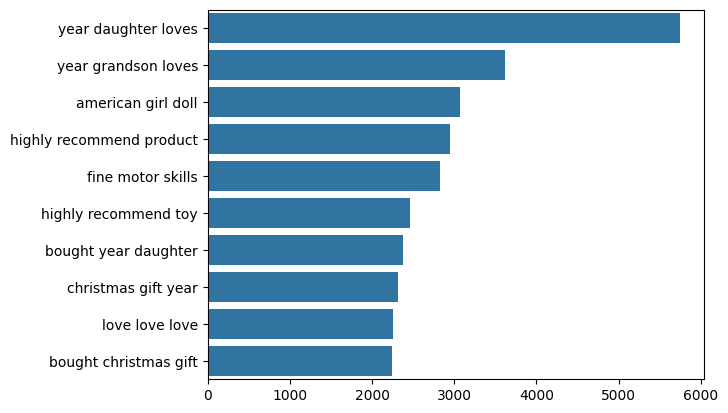

In [9]:
calculaNGrams(juguetesDF.loc[juguetesDF['class'] == 1, :].words, 3)

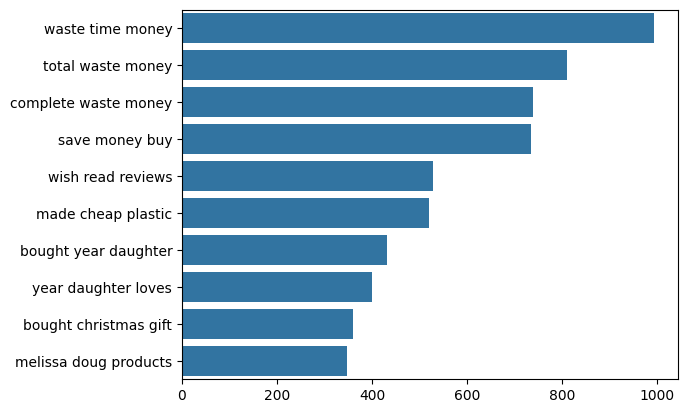

In [10]:
calculaNGrams(juguetesDF.loc[juguetesDF['class'] == 0, :].words, 3)

### Análisis de sentimiento

In [11]:
from pysentimiento import create_analyzer

analyzer = create_analyzer(task="sentiment", lang='en')

d:\Workspace\ML_learning_gate\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Workspace\ML_learning_gate\ml_env\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
sample = juguetesDF.sample(20000, random_state=100)

In [13]:
reviews = sample.reviewText.tolist()
sentimientos = analyzer.predict(reviews)

Map: 100%|██████████| 20000/20000 [00:08<00:00, 2496.55 examples/s]


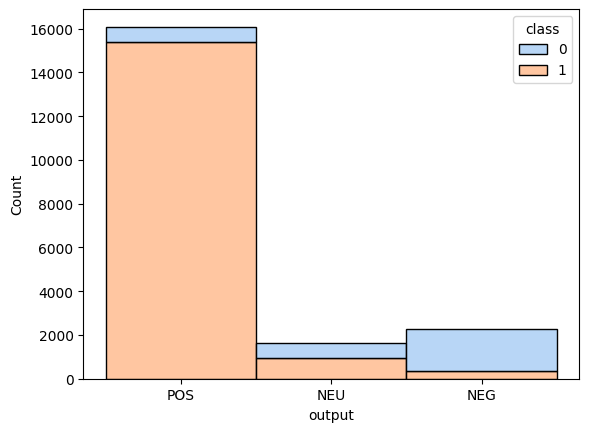

In [25]:
probs = obtenProbabilidades(sample, sentimientos)
sns.histplot(data=probs, hue='class', x='output', palette="pastel", multiple="stack");

C:\Users\PC\AppData\Local\Temp\ipykernel_32484\2020302575.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


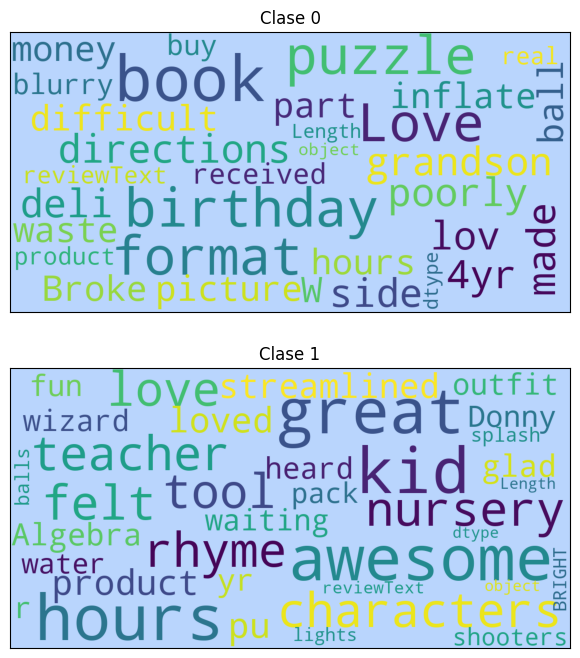

In [23]:
class0_word_cloud = nube_palabras(juguetesDF.loc[juguetesDF['class'] == 0, :].reviewText, '#b9d5fd')
class1_word_cloud = nube_palabras(juguetesDF.loc[juguetesDF['class'] == 1, :].reviewText, '#b9d5fd')

fig, (ax0, ax1) = plt.subplots(2,1, figsize=(10,8)) 

ax0.imshow(class0_word_cloud)
ax0.set(xlabel=None, ylabel=None, xticks=[], yticks=[], title='Clase 0')
ax1.imshow(class1_word_cloud)
ax1.set(xlabel=None, ylabel=None, xticks=[], yticks=[], title='Clase 1')
fig.show();

### Visualización UMAP

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None
)
documentos = tfidf.fit_transform(sample.words)

In [28]:
sample['class'] = sample['class'].astype(np.uint8)

d:\Workspace\ML_learning_gate\ml_env\Lib\site-packages\yellowbrick\text\umap_vis.py:359: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


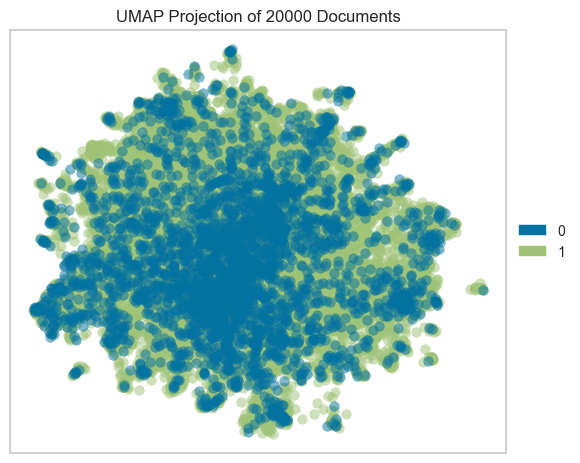

In [46]:
from yellowbrick.text import UMAPVisualizer

umap = UMAPVisualizer(metric= 'cosine', n_neighbors=15, alpha=0.5, min_dist=0.25)
umap.fit(documentos, sample['class'])
umap.show();

### Conclusión

En general se aprecia una recepción positiva de los juguetes con un tamaño de longitud de texto en las reseñas mayormente alrededor de 25 palabras, pero cuando se compara el análisis de sentimiento y nube de palabras entre las 2 clases vemos que la clase 0 tiene muchas más críticas negativas, asi como las palabras más frecuentes de esta son relacionadas a la mala calidad del producto (hablan principalmente del plastico barato y productos de la marca melissa & doug). Las clases están desbalanceadas pero en una muestra de 20,000 reseñas la visualización por UMAP muestra un mayor indice de la clasificación 0 (la clase con el 16% de las muestras) lo que muestra un contexto similar con la clase 1.

Se puede usar esta información para entender que existe una mayor inconformidad con los productos de la clase 0 y realizar a partir de ahi un estudio para encontrar las similitudes de entre estos usuarios (tipo de producto, material o precio)